# Survival Analysis Project

1. Load and inspect the dataset
2. Clean and preprocess the data
3. Explore basic survival curves using Kaplan-Meier
4. Compare survival between age groups with log-rank tests
5. Fit a Cox proportional hazards model
6. Visualize hazard ratios and assess model assumptions


In [ ]:
!pip install pandas numpy matplotlib seaborn lifelines scikit-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 2.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=f31d8d2c2491680f3f10088e536e9b3afc6f2d60950504df6182502dbdc4b493
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


Data Loading and Inspection

In [ ]:
from lifelines.datasets import load_gbsg2
import pandas as pd

df = load_gbsg2()

df['patient_id'] = range(1, len(df)+1)

cols = ['patient_id'] + [c for c in df.columns if c != 'patient_id']
df = df[cols]

df = df.rename(columns={'time': 'time', 'cens': 'event'})

df.to_csv("clinical_data.csv", index=False)

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Dataset shape: (686, 11)
Columns: ['patient_id', 'horTh', 'age', 'menostat', 'tsize', 'tgrade', 'pnodes', 'progrec', 'estrec', 'time', 'event']


,patient_id,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,event
0,1,no,70,Post,21,II,3,48,66,1814,1
1,2,yes,56,Post,12,II,7,61,77,2018,1
2,3,yes,58,Post,35,II,9,52,271,712,1
3,4,yes,59,Post,17,II,4,60,29,1807,1
4,5,no,73,Post,35,II,1,26,65,772,1


Data Cleaning and Preprocessing

In [ ]:
print("Column types:")
print(df.dtypes)

print("\nMissing values per column (percent):")
print((df.isnull().mean()*100).sort_values(ascending=False))

num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = df.select_dtypes(include='category').columns.tolist()
print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Column types:
patient_id     int64
horTh         object
age            int64
menostat      object
tsize          int64
tgrade        object
pnodes         int64
progrec        int64
estrec         int64
time           int64
event          int64
dtype: object

Missing values per column (percent):
patient_id    0.0
horTh         0.0
age           0.0
menostat      0.0
tsize         0.0
tgrade        0.0
pnodes        0.0
progrec       0.0
estrec        0.0
time          0.0
event         0.0
dtype: float64

Numeric columns: ['patient_id', 'age', 'tsize', 'pnodes', 'progrec', 'estrec', 'time', 'event']
Categorical columns: []


In [ ]:
df['time'] = pd.to_numeric(df['time'], errors='coerce')
df['event'] = df['event'].apply(lambda x: 1 if x == 1 else 0)
df[['time','event']].head()


,time,event
0,1814,1
1,2018,1
2,712,1
3,1807,1
4,772,1


In [ ]:
df['time'] = (df['time'] / 30.44).round(1)
print(df['time'].describe())


count    686.000000
mean      36.940087
std       21.116379
min        0.300000
25%       18.625000
50%       35.600000
75%       55.375000
max       87.400000
Name: time, dtype: float64


In [ ]:
df_proc = df.copy()

cat_cols = df_proc.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df_proc[col] = df_proc[col].astype('category')

num_cols = df_proc.select_dtypes(include='number').columns.tolist()
cat_cols = df_proc.select_dtypes(include='category').columns.tolist()

for col in num_cols:
    df_proc[col] = df_proc[col].fillna(df_proc[col].mean())

for col in cat_cols:
    df_proc[col] = df_proc[col].fillna(df_proc[col].mode().iloc[0])

missing_after = df_proc.isnull().sum()
print("Missing values per column after cleaning:")
print(missing_after)

df_proc.to_csv("clinical_data_clean.csv", index=False)

print("\nShape of df_proc:", df_proc.shape)
df_proc.head()


Missing values per column after cleaning:
patient_id    0
horTh         0
age           0
menostat      0
tsize         0
tgrade        0
pnodes        0
progrec       0
estrec        0
time          0
event         0
dtype: int64

Shape of df_proc: (686, 11)


,patient_id,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,event
0,1,no,70,Post,21,II,3,48,66,59.6,1
1,2,yes,56,Post,12,II,7,61,77,66.3,1
2,3,yes,58,Post,35,II,9,52,271,23.4,1
3,4,yes,59,Post,17,II,4,60,29,59.4,1
4,5,no,73,Post,35,II,1,26,65,25.4,1


Kaplan-Meier Survival Analysis

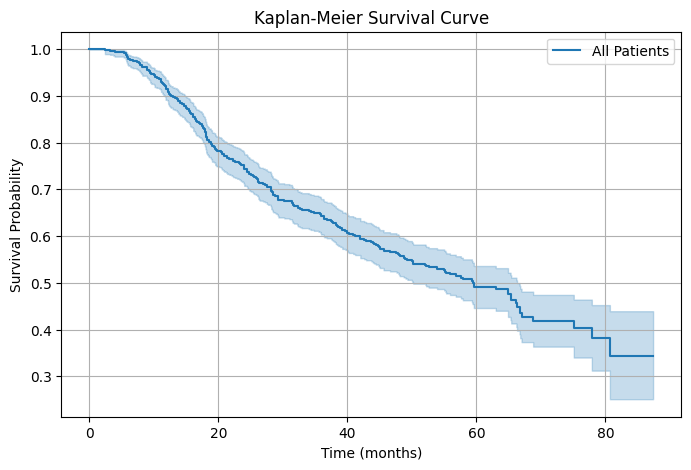

Skipping group 80+, no valid patients


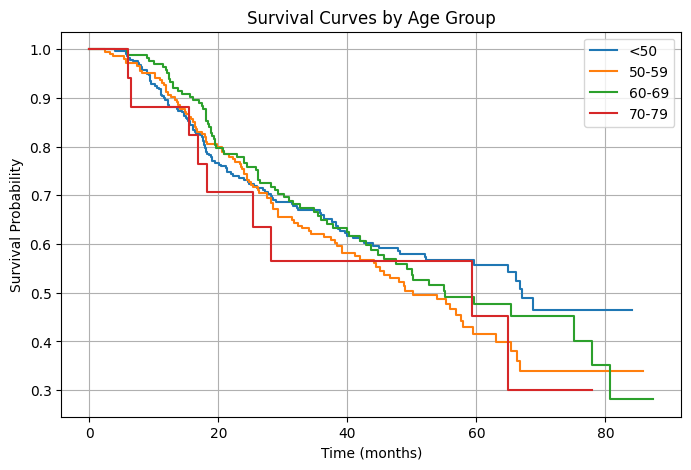

In [ ]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import pandas as pd

kmf = KaplanMeierFitter()

df_proc['time'] = pd.to_numeric(df_proc['time'], errors='coerce')
df_proc['event'] = pd.to_numeric(df_proc['event'], errors='coerce')

kmf.fit(durations=df_proc['time'], event_observed=df_proc['event'], label='All Patients')
plt.figure(figsize=(8,5))
kmf.plot(ci_show=True)
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

if 'age_group' in df_proc.columns:
    plt.figure(figsize=(8,5))
    for group in df_proc['age_group'].cat.categories:
        mask = df_proc['age_group'] == group
        durations = pd.to_numeric(df_proc.loc[mask, 'time'], errors='coerce')
        events = pd.to_numeric(df_proc.loc[mask, 'event'], errors='coerce')

        if durations.dropna().empty:
            print(f"Skipping group {group}, no valid patients")
            continue

        kmf.fit(durations=durations, event_observed=events, label=str(group))
        kmf.plot(ci_show=False)

    plt.title("Survival Curves by Age Group")
    plt.xlabel("Time (months)")
    plt.ylabel("Survival Probability")
    plt.grid(True)
    plt.show()


Survival Probabilities and Survival By Age Group

In [ ]:
import pandas as pd
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

kmf.fit(durations=pd.to_numeric(df_proc['time'], errors='coerce'),
        event_observed=pd.to_numeric(df_proc['event'], errors='coerce'),
        label='All Patients')

median_surv = kmf.median_survival_time_
print("Median survival time (all patients, months):", median_surv)

time_points = [12, 24, 36, 60]
surv_probs = kmf.predict(time_points)
surv_df = pd.DataFrame({'Time (months)': time_points, 'Survival Probability': surv_probs.values})
print("\nOverall survival probabilities at selected times:")
print(surv_df)

ci_df = kmf.confidence_interval_.reindex(time_points, method='nearest')
ci_df.columns = ['Lower CI', 'Upper CI']
print("\nApproximate 95% confidence intervals at selected times:")
print(ci_df)

if 'age_group' in df_proc.columns:
    print("\nSurvival by Age Group:")
    age_metrics = []

    for group in df_proc['age_group'].cat.categories:
        mask = df_proc['age_group'] == group
        durations = pd.to_numeric(df_proc.loc[mask, 'time'], errors='coerce')
        events = pd.to_numeric(df_proc.loc[mask, 'event'], errors='coerce')

        if len(durations) == 0 or durations.isna().all():
            print(f"Skipping group {group}, no valid patients")
            continue

        kmf.fit(durations=durations, event_observed=events, label=str(group))
        median = kmf.median_survival_time_
        surv_probs_group = kmf.predict(time_points).values

        ci_group = kmf.confidence_interval_.reindex(time_points, method='nearest')
        ci_group.columns = ['Lower CI', 'Upper CI']

        age_metrics.append([group, median] + list(surv_probs_group) + [ci_group.iloc[0,0], ci_group.iloc[0,1]])

    columns = ['Age Group', 'Median Survival'] + [f'Survival at {t} mo' for t in time_points] + ['CI Lower at 12 mo', 'CI Upper at 12 mo']
    age_metrics_df = pd.DataFrame(age_metrics, columns=columns)
    print(age_metrics_df)


Median survival time (all patients, months): 59.4

Overall survival probabilities at selected times:
   Time (months)  Survival Probability
0             12              0.915560
1             24              0.743005
2             36              0.642709
3             60              0.491850

Approximate 95% confidence intervals at selected times:
    Lower CI  Upper CI
12  0.889994  0.933027
24  0.707511  0.774895
36  0.603400  0.679203
60  0.446017  0.536003

Survival by Age Group:
Skipping group 80+, no valid patients
  Age Group  Median Survival  Survival at 12 mo  Survival at 24 mo  \
0       <50             67.0           0.895841           0.732142   
1     50-59             50.1           0.911208           0.743105   
2     60-69             55.2           0.957570           0.765659   
3     70-79             59.3           0.882353           0.705882   

   Survival at 36 mo  Survival at 60 mo  CI Lower at 12 mo  CI Upper at 12 mo  
0           0.659956           0.556881

Skipping group 80+ because it has no data


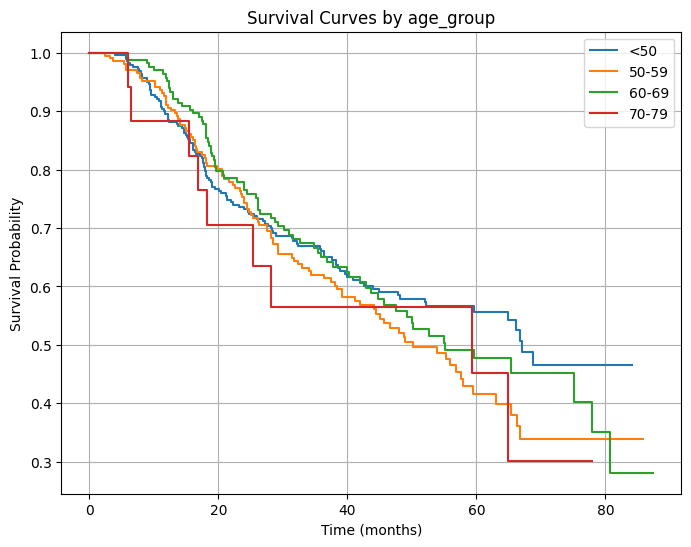

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

group_col = 'age_group'

if group_col in df_proc.columns:
    plt.figure(figsize=(8,6))
    kmf = KaplanMeierFitter()

    groups = df_proc[group_col].cat.categories

    for g in groups:
        mask = (df_proc[group_col] == g) & df_proc['time'].notnull() & df_proc['event'].notnull()
        if mask.sum() == 0:
            print(f"Skipping group {g} because it has no data")
            continue

        durations = pd.to_numeric(df_proc.loc[mask, 'time'], errors='coerce')
        events = pd.to_numeric(df_proc.loc[mask, 'event'], errors='coerce')

        valid = durations.notnull() & events.notnull()
        durations = durations[valid]
        events = events[valid]

        kmf.fit(durations=durations, event_observed=events, label=str(g))
        kmf.plot(ci_show=False)

    plt.title(f"Survival Curves by {group_col}")
    plt.xlabel("Time (months)")
    plt.ylabel("Survival Probability")
    plt.grid(True)
    plt.show()


In [ ]:
df_proc['age'] = pd.to_numeric(df_proc['age'], errors='coerce')

df_proc['age_group'] = pd.cut(
    df_proc['age'],
    bins=[0, 40, 60, 80, 200],
    labels=['<40', '40-59', '60-79', '80+']
)

print(df_proc['age_group'].value_counts(dropna=False))


age_group
40-59    425
60-79    188
<40       73
80+        0
Name: count, dtype: int64


Log Rank Test Between Groups

In [ ]:
from lifelines.statistics import logrank_test

group_col = "age_group"

if group_col in df_proc.columns:
    groups = df_proc[group_col].cat.categories

    if len(groups) >= 2:
        g1, g2 = groups[0], groups[1]
        mask1 = df_proc[group_col] == g1
        mask2 = df_proc[group_col] == g2

        lr = logrank_test(
            df_proc.loc[mask1, "time"],
            df_proc.loc[mask2, "time"],
            df_proc.loc[mask1, "event"],
            df_proc.loc[mask2, "event"]
        )

        print(f"Log-rank test between {g1} and {g2}:")
        print("Test statistic:", lr.test_statistic)
        print("p-value:", lr.p_value)
    else:
        print("Not enough groups to run a log-rank test.")
else:
    print(f"{group_col} not found in df_proc.")


Log-rank test between <40 and 40-59:
Test statistic: 5.848507746235683
p-value: 0.015590265788228535


In [ ]:
df_proc['age_group'] = pd.cut(
    df_proc['age'],
    bins=[0, 50, 60, 70, 80, 200],
    labels=['<50', '50-59', '60-69', '70-79', '80+']
)

In [ ]:
df_dummies = pd.get_dummies(df_proc['age_group'], prefix='age_group', drop_first=True)
df_cox = pd.concat([df_proc[['time', 'event']], df_dummies], axis=1)

Cox Proportional Hazards Model

In [ ]:
if df_cox['age_group_80+'].var() < 1e-3:
    df_cox = df_cox.drop(columns=['age_group_80+'])

In [ ]:
from lifelines import CoxPHFitter

if 'age_group_80+' in df_cox.columns and df_cox['age_group_80+'].var() < 1e-3:
    df_cox = df_cox.drop(columns=['age_group_80+'])

cph = CoxPHFitter()
cph.fit(df_cox, duration_col='time', event_col='event')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 299
   partial log-likelihood = -1787.00
         time fit was run = 2025-12-09 03:15:54 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
age_group_50-59  0.21      1.24      0.14           -0.06            0.48                0.95                1.62
age_group_60-69  0.07      1.07      0.15           -0.22            0.36                0.80                1.44
age_group_70-79  0.25      1.29      0.35           -0.43            0.93                0.65                2.54

                 cmp to    z    p  -log2(p)
covariate                                  
age_group_50-59    0.00 1.56 0.12      3.07
age_group_60-69    0.00 0.48 0.63      0.67
age_group_70-79    0.00 0.73 0.46      1.11
---
Concordance = 0.51
Partial AIC = 3580.00
log-likelihood ratio test = 2.67 on 3 df
-log2(p) of ll-ratio test = 1.16

Cox Model Hazard Ratios

In [ ]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, df_cox, time_transform='rank')
results.print_summary()

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
         test_name = proportional_hazard_test

---
                 test_statistic    p  -log2(p)
age_group_50-59            5.63 0.02      5.83
age_group_60-69            7.55 0.01      7.38
age_group_70-79            0.03 0.87      0.20


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
         test_name = proportional_hazard_test

---
                      test_statistic    p  -log2(p)
age_group_50-59 km              5.33 0.02      5.58
                rank            5.63 0.02      5.83
age_group_60-69 km              7.23 0.01      7.12
                rank            7.55 0.01      7.38
age_group_70-79 km              0.05 0.82      0.29
                rank            0.03 0.87      0.20



1. Variable 'age_group_50-59' failed the non-proportional test: p-value is 0.0176.

   Advice: with so few unique values (only 2), you can include `strata=['age_group_50-59', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'age_group_60-69' failed the non-proportional test: p-value is 0.0060.

   Advice: with so few unique values (only 2), you can include `strata=['age_group_60-69', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifel

[[<Axes: xlabel='rank-transformed time\n(p=0.0176)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0210)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0060)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0072)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8689)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8183)'>]]

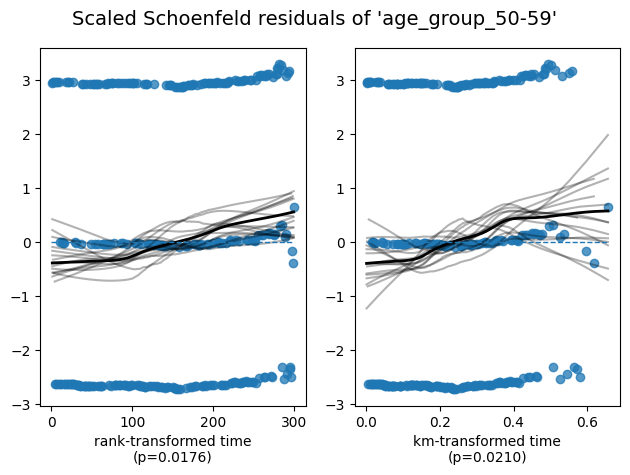

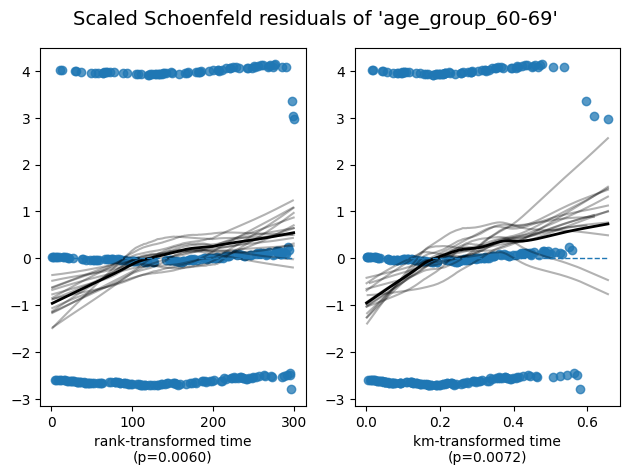

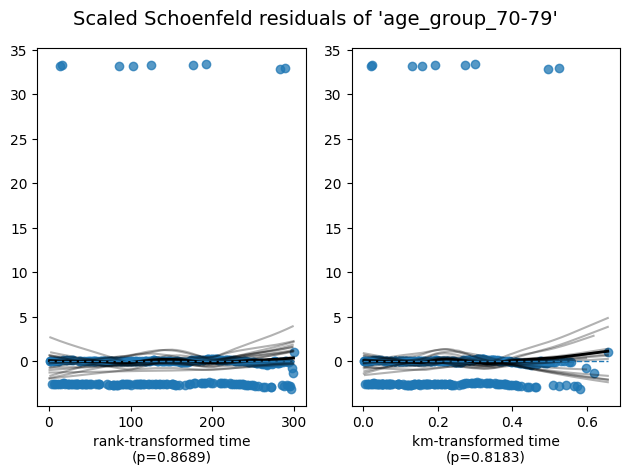

In [ ]:
cph.check_assumptions(df_cox, p_value_threshold=0.05, show_plots=True)

In [ ]:
summary_df = cph.summary.copy()

summary_df['HR'] = summary_df['exp(coef)']
summary_df['HR_lower'] = summary_df['exp(coef) lower 95%']
summary_df['HR_upper'] = summary_df['exp(coef) upper 95%']

display_cols = ['coef', 'HR', 'HR_lower', 'HR_upper', 'p']
print("Cox Model Summary with Hazard Ratios:")
display(summary_df[display_cols])


Cox Model Summary with Hazard Ratios:


,coef,HR,HR_lower,HR_upper,p
covariate,,,,,
age_group_50-59,0.213017,1.237406,0.946480,1.617756,0.119299
age_group_60-69,0.071801,1.074441,0.802623,1.438314,0.629461
age_group_70-79,0.253137,1.288059,0.653294,2.539588,0.464880


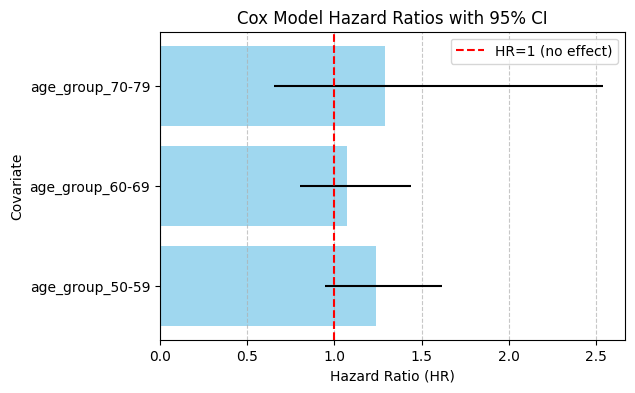

In [ ]:
import matplotlib.pyplot as plt

summary_df = cph.summary.copy()
summary_df['HR'] = summary_df['exp(coef)']
summary_df['HR_lower'] = summary_df['exp(coef) lower 95%']
summary_df['HR_upper'] = summary_df['exp(coef) upper 95%']

plt.figure(figsize=(6,4))
plt.barh(
    summary_df.index,
    summary_df['HR'],
    xerr=[summary_df['HR'] - summary_df['HR_lower'], summary_df['HR_upper'] - summary_df['HR']],
    color='skyblue',
    alpha=0.8
)
plt.axvline(1, color='red', linestyle='--', label='HR=1 (no effect)')
plt.xlabel("Hazard Ratio (HR)")
plt.ylabel("Covariate")
plt.title("Cox Model Hazard Ratios with 95% CI")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
